In [1]:
# ============================================================
# БЛОК 1: ИМПОРТЫ И НАСТРОЙКА ОКРУЖЕНИЯ
# ============================================================
# Здесь мы импортируем все необходимые библиотеки для работы

import torch
import torch.nn as nn  # Для создания нейронных сетей
import torch.optim as optim  # Для оптимизаторов (Adam, SGD и т.д.)
from torch.utils.data import DataLoader, random_split  # Для загрузки данных батчами

import torchvision  # Библиотека с готовыми датасетами и трансформациями
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt  # Для визуализации
from sklearn.metrics import confusion_matrix  # Для матрицы ошибок
import seaborn as sns  # Для красивой визуализации confusion matrix

# Проверяем, доступна ли GPU (ускорит обучение в ~10-100 раз)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

# Устанавливаем seed для воспроизводимости результатов
# (чтобы при повторном запуске получить те же результаты)
torch.manual_seed(42)
np.random.seed(42)

Используемое устройство: cpu


Загрузка датасета MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 24.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 611kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.20MB/s]

Размер обучающей выборки: 54000
Размер валидационной выборки: 6000
Размер тестовой выборки: 10000

Примеры изображений из датасета:


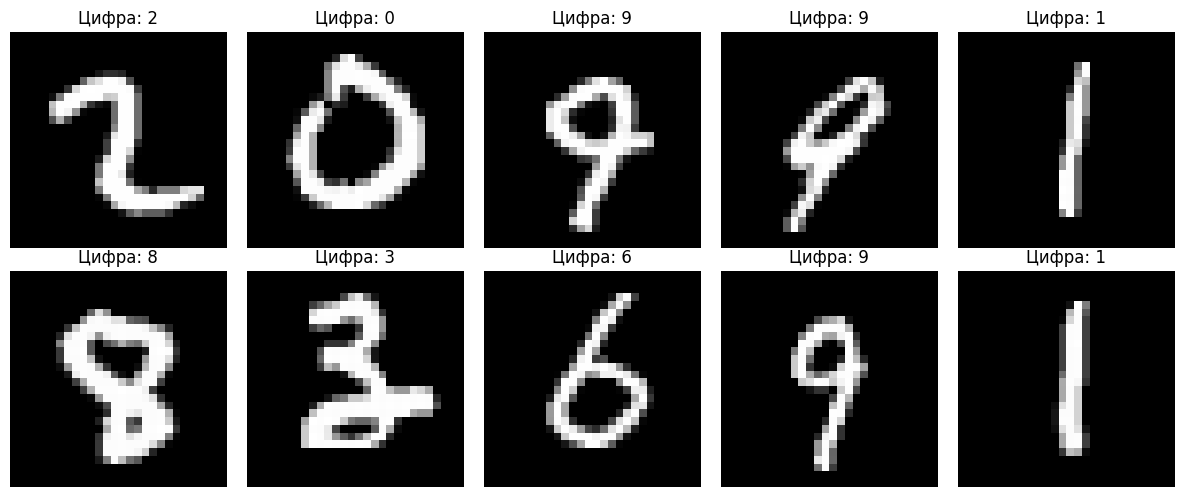


Форма одного изображения: torch.Size([1, 28, 28])
Форма батча: torch.Size([128, 1, 28, 28])


In [2]:
# ============================================================
# БЛОК 2: ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ============================================================

# Шаг 1: Определяем трансформации для данных
# -------------------------------------------
# ToTensor() - преобразует изображение PIL/numpy в тензор PyTorch
# Normalize() - нормализует данные (mean=0.5, std=0.5 переводит значения из [0,1] в [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем в тензор (значения от 0 до 1)
    transforms.Normalize((0.5,), (0.5,))  # Нормализуем: (x - 0.5) / 0.5
])

# Шаг 2: Загружаем датасет MNIST
# -------------------------------------------
# MNIST содержит 60000 обучающих и 10000 тестовых изображений цифр 28x28 пикселей
print('Загрузка датасета MNIST...')

# Загружаем полный обучающий датасет (60000 изображений)
full_train_dataset = datasets.MNIST(
    root='./data',  # Папка для сохранения данных
    train=True,  # Берем обучающую часть
    download=True,  # Скачиваем, если данных нет
    transform=transform  # Применяем наши трансформации
)

# Загружаем тестовый датасет (10000 изображений)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,  # Берем тестовую часть
    download=True,
    transform=transform
)

# Шаг 3: Разделяем train на train и validation (90% / 10%)
# -------------------------------------------
# Это нужно для честной оценки модели во время обучения
train_size = int(0.9 * len(full_train_dataset))  # 54000 изображений
val_size = len(full_train_dataset) - train_size  # 6000 изображений

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Для воспроизводимости
)

print(f'Размер обучающей выборки: {len(train_dataset)}')
print(f'Размер валидационной выборки: {len(val_dataset)}')
print(f'Размер тестовой выборки: {len(test_dataset)}')

# Шаг 4: Создаем DataLoader для эффективной загрузки данных батчами
# -------------------------------------------
# DataLoader автоматически:
# - разбивает данные на батчи
# - перемешивает данные (shuffle=True)
# - загружает данные параллельно (num_workers)

batch_size = 128  # Количество изображений в одном батче

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Перемешиваем данные каждую эпоху (важно для обучения!)
    num_workers=2  # Количество процессов для загрузки данных
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Валидацию не перемешиваем
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Тест не перемешиваем
    num_workers=2
)

# Шаг 5: Визуализируем несколько примеров из датасета
# -------------------------------------------
print('\nПримеры изображений из датасета:')

# Получаем один батч данных
examples = iter(train_loader)
example_data, example_targets = next(examples)

# Показываем первые 10 изображений
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # Преобразуем тензор обратно в изображение
    img = example_data[i].squeeze()  # Убираем лишнее измерение
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Цифра: {example_targets[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'\nФорма одного изображения: {example_data[0].shape}')  # [1, 28, 28]
print(f'Форма батча: {example_data.shape}')  # [batch_size, 1, 28, 28]

In [3]:
# ============================================================
# БЛОК 3: ОПРЕДЕЛЕНИЕ МОДЕЛИ (MLP - МНОГОСЛОЙНЫЙ ПЕРСЕПТРОН)
# ============================================================

class MLP(nn.Module):
    """
    Многослойный персептрон (Multi-Layer Perceptron)

    Архитектура:
    Input (784) -> Linear(784, 256) -> ReLU -> Dropout(0.2) ->
    Linear(256, 128) -> ReLU -> Dropout(0.2) ->
    Linear(128, 10) -> Output (10 классов)
    """

    def __init__(self, input_size=784, hidden1=256, hidden2=128, num_classes=10, dropout_rate=0.2):
        """
        Конструктор модели

        Параметры:
        - input_size: размер входа (28*28 = 784 для MNIST)
        - hidden1: количество нейронов в первом скрытом слое
        - hidden2: количество нейронов во втором скрытом слое
        - num_classes: количество выходных классов (10 цифр: 0-9)
        - dropout_rate: вероятность dropout (для регуляризации)
        """
        super(MLP, self).__init__()

        # Первый полносвязный слой: 784 входа -> 256 выходов
        self.fc1 = nn.Linear(input_size, hidden1)

        # Второй полносвязный слой: 256 входов -> 128 выходов
        self.fc2 = nn.Linear(hidden1, hidden2)

        # Третий полносвязный слой (выходной): 128 входов -> 10 выходов
        self.fc3 = nn.Linear(hidden2, num_classes)

        # Функция активации ReLU (преобразует отрицательные значения в 0)
        self.relu = nn.ReLU()

        # Dropout для регуляризации (случайно "выключает" нейроны при обучении)
        # Это помогает избежать переобучения
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Прямой проход (forward pass) через сеть

        Параметры:
        - x: входной тензор формы [batch_size, 1, 28, 28]

        Возвращает:
        - out: выходной тензор формы [batch_size, 10] (логиты для 10 классов)
        """

        # Шаг 1: Преобразуем изображение из формы [batch_size, 1, 28, 28]
        #         в вектор формы [batch_size, 784]
        x = x.view(x.size(0), -1)  # Flatten: делаем из матрицы вектор

        # Шаг 2: Первый слой + активация + dropout
        x = self.fc1(x)      # [batch_size, 784] -> [batch_size, 256]
        x = self.relu(x)     # Применяем ReLU
        x = self.dropout(x)  # Применяем dropout (только во время обучения!)

        # Шаг 3: Второй слой + активация + dropout
        x = self.fc2(x)      # [batch_size, 256] -> [batch_size, 128]
        x = self.relu(x)
        x = self.dropout(x)

        # Шаг 4: Выходной слой (без активации! CrossEntropyLoss применит softmax)
        out = self.fc3(x)    # [batch_size, 128] -> [batch_size, 10]

        return out


# Создаем экземпляр модели и переносим на устройство (GPU или CPU)
model = MLP().to(device)

# Выводим информацию о модели
print('Архитектура модели:')
print(model)
print('\n' + '='*60)

# Подсчитываем количество обучаемых параметров
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Общее количество обучаемых параметров: {total_params:,}')
print('='*60)

# Проверяем работу модели на примере
with torch.no_grad():  # Отключаем вычисление градиентов
    sample_input = torch.randn(1, 1, 28, 28).to(device)  # Случайное изображение
    sample_output = model(sample_input)
    print(f'\nФорма входа: {sample_input.shape}')
    print(f'Форма выхода: {sample_output.shape}')
    print(f'Пример выхода (логиты): {sample_output[0].cpu().numpy()}')

Архитектура модели:
MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Общее количество обучаемых параметров: 235,146

Форма входа: torch.Size([1, 1, 28, 28])
Форма выхода: torch.Size([1, 10])
Пример выхода (логиты): [ 0.17421469 -0.02710439 -0.10737211 -0.23570263 -0.06744696  0.02530478
 -0.00801104  0.01177571 -0.17946595  0.00570373]


In [5]:
# ============================================================
# БЛОК 4: ФУНКЦИЯ ПОТЕРЬ И ОПТИМИЗАТОР
# ============================================================

# Функция потерь (Loss Function)
# -------------------------------------------
# CrossEntropyLoss - стандартная функция для классификации
# Она объединяет Softmax и Negative Log Likelihood Loss
# Важно: модель должна выдавать "сырые" логиты (без softmax)!
criterion = nn.CrossEntropyLoss()

# Оптимизатор
# -------------------------------------------
# Adam - адаптивный оптимизатор, который хорошо работает в большинстве случаев
# lr (learning rate) - скорость обучения, контролирует размер шагов при обновлении весов
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # lr = 0.001

print('Настройки обучения:')
print(f'Функция потерь: {criterion}')
print(f'Оптимизатор: {optimizer}')
print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')

# Опционально: планировщик learning rate
# -------------------------------------------
# Уменьшает learning rate в процессе обучения для лучшей сходимости
# ReduceLROnPlateau уменьшает lr, когда метрика перестает улучшаться
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # Следим за уменьшением loss
    factor=0.5,      # Уменьшаем lr в 2 раза
    patience=2,      # Ждем 2 эпохи без улучшения
)

print(f'Планировщик LR: {scheduler}')

Настройки обучения:
Функция потерь: CrossEntropyLoss()
Оптимизатор: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001
Планировщик LR: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7d09b2d4db20>


In [6]:
# ============================================================
# БЛОК 5: ФУНКЦИИ ДЛЯ ОБУЧЕНИЯ И ВАЛИДАЦИИ
# ============================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Обучение модели на одной эпохе

    Параметры:
    - model: нейронная сеть
    - dataloader: загрузчик данных
    - criterion: функция потерь
    - optimizer: оптимизатор
    - device: устройство (CPU или GPU)

    Возвращает:
    - avg_loss: средняя loss за эпоху
    - accuracy: точность на обучающей выборке
    """

    # Переводим модель в режим обучения
    # (включает dropout и batch normalization)
    model.train()

    running_loss = 0.0  # Накопленная loss
    correct = 0  # Количество правильных предсказаний
    total = 0  # Общее количество примеров

    # Проходим по всем батчам
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Переносим данные на устройство (GPU/CPU)
        images = images.to(device)
        labels = labels.to(device)

        # ШАГ 1: Обнуляем градиенты
        # (градиенты накапливаются, поэтому их нужно обнулять перед каждым батчем)
        optimizer.zero_grad()

        # ШАГ 2: Прямой проход (forward pass)
        outputs = model(images)  # Получаем предсказания модели

        # ШАГ 3: Вычисляем loss
        loss = criterion(outputs, labels)

        # ШАГ 4: Обратный проход (backward pass)
        # Вычисляем градиенты для всех параметров
        loss.backward()

        # ШАГ 5: Обновляем веса модели
        optimizer.step()

        # Статистика
        running_loss += loss.item()  # Накапливаем loss

        # Вычисляем точность
        _, predicted = torch.max(outputs.data, 1)  # Берем класс с максимальной вероятностью
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Выводим прогресс каждые 100 батчей
        if (batch_idx + 1) % 100 == 0:
            print(f'  Батч [{batch_idx + 1}/{len(dataloader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Accuracy: {100 * correct / total:.2f}%')

    # Вычисляем средние значения за эпоху
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Валидация модели (оценка на валидационной/тестовой выборке)

    Параметры:
    - model: нейронная сеть
    - dataloader: загрузчик данных
    - criterion: функция потерь
    - device: устройство (CPU или GPU)

    Возвращает:
    - avg_loss: средняя loss
    - accuracy: точность
    """

    # Переводим модель в режим оценки
    # (отключает dropout и batch normalization)
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # Отключаем вычисление градиентов (экономит память и ускоряет работу)
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Статистика
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


print('Функции обучения и валидации готовы!')

Функции обучения и валидации готовы!


In [7]:
# ============================================================
# БЛОК 6: ОСНОВНОЙ ЦИКЛ ОБУЧЕНИЯ
# ============================================================

# Настройки обучения
num_epochs = 10  # Количество эпох (полных проходов по датасету)

# Списки для хранения истории обучения (для графиков)
train_losses = []  # Loss на обучающей выборке
val_losses = []    # Loss на валидационной выборке
train_accuracies = []  # Accuracy на обучающей выборке
val_accuracies = []    # Accuracy на валидационной выборке

print('='*70)
print('НАЧАЛО ОБУЧЕНИЯ')
print('='*70)

# Основной цикл по эпохам
for epoch in range(num_epochs):
    print(f'\nЭпоха {epoch + 1}/{num_epochs}')
    print('-' * 70)

    # ===== ОБУЧЕНИЕ =====
    print('Обучение...')
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f'  Средняя Train Loss: {train_loss:.4f}')
    print(f'  Train Accuracy: {train_acc:.2f}%')

    # ===== ВАЛИДАЦИЯ =====
    print('Валидация...')
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'  Validation Loss: {val_loss:.4f}')
    print(f'  Validation Accuracy: {val_acc:.2f}%')

    # Обновляем learning rate (если валидационная loss не улучшается)
    scheduler.step(val_loss)

    # Сохраняем лучшую модель
    if epoch == 0 or val_loss < min(val_losses[:-1]):
        print('  ✓ Сохраняем лучшую модель!')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
        }, 'best_model.pth')

print('\n' + '='*70)
print('ОБУЧЕНИЕ ЗАВЕРШЕНО!')
print('='*70)

# Загружаем лучшую модель для финальной оценки
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nЗагружена лучшая модель с эпохи {checkpoint['epoch'] + 1}")
print(f"Validation Accuracy: {checkpoint['val_accuracy']:.2f}%")

НАЧАЛО ОБУЧЕНИЯ

Эпоха 1/10
----------------------------------------------------------------------
Обучение...
  Батч [100/422], Loss: 0.3362, Accuracy: 72.01%
  Батч [200/422], Loss: 0.4773, Accuracy: 79.98%
  Батч [300/422], Loss: 0.3091, Accuracy: 83.23%
  Батч [400/422], Loss: 0.2004, Accuracy: 85.14%
  Средняя Train Loss: 0.4650
  Train Accuracy: 85.51%
Валидация...
  Validation Loss: 0.2265
  Validation Accuracy: 93.22%
  ✓ Сохраняем лучшую модель!

Эпоха 2/10
----------------------------------------------------------------------
Обучение...
  Батч [100/422], Loss: 0.2178, Accuracy: 92.86%
  Батч [200/422], Loss: 0.2622, Accuracy: 92.99%
  Батч [300/422], Loss: 0.2668, Accuracy: 93.24%
  Батч [400/422], Loss: 0.1316, Accuracy: 93.46%
  Средняя Train Loss: 0.2183
  Train Accuracy: 93.47%
Валидация...
  Validation Loss: 0.1635
  Validation Accuracy: 95.13%
  ✓ Сохраняем лучшую модель!

Эпоха 3/10
----------------------------------------------------------------------
Обучение...
  Б

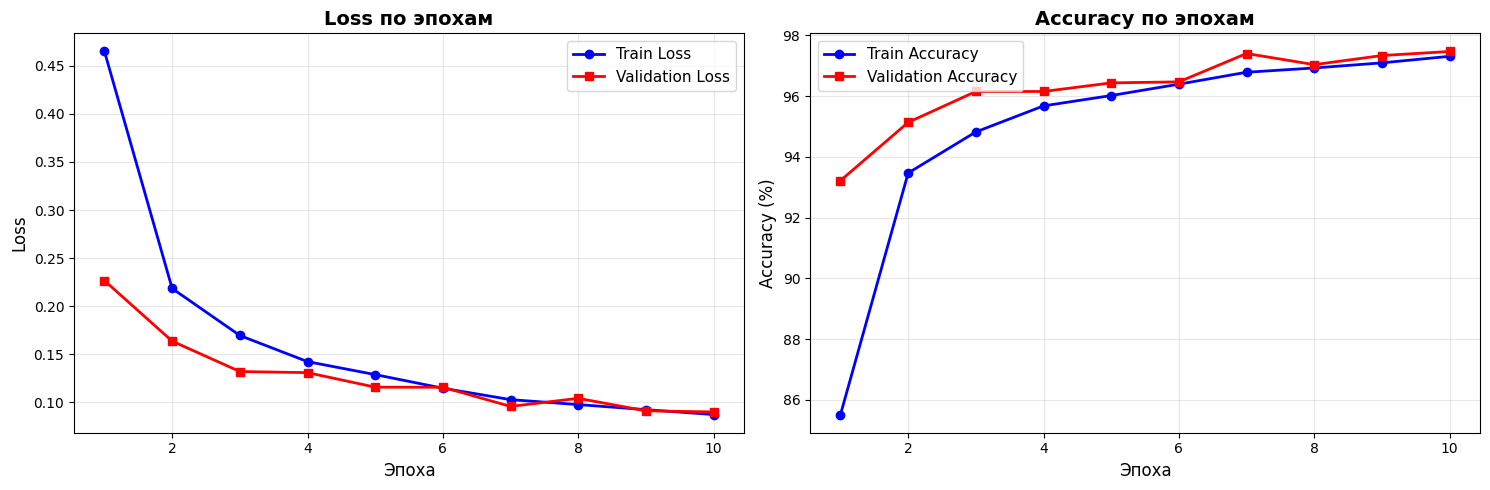


Финальные результаты обучения:
Финальная Train Loss: 0.0871
Финальная Validation Loss: 0.0898
Финальная Train Accuracy: 97.31%
Финальная Validation Accuracy: 97.47%
Лучшая Validation Loss: 0.0898 (эпоха 10)
Лучшая Validation Accuracy: 97.47% (эпоха 10)


In [8]:
# ============================================================
# БЛОК 7: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
# ============================================================

# График 1: Loss по эпохам
# -------------------------------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-o', label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), val_losses, 'r-s', label='Validation Loss', linewidth=2)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss по эпохам', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# График 2: Accuracy по эпохам
# -------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-o', label='Train Accuracy', linewidth=2)
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy по эпохам', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим финальные результаты
print('\nФинальные результаты обучения:')
print(f'Финальная Train Loss: {train_losses[-1]:.4f}')
print(f'Финальная Validation Loss: {val_losses[-1]:.4f}')
print(f'Финальная Train Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Финальная Validation Accuracy: {val_accuracies[-1]:.2f}%')
print(f'Лучшая Validation Loss: {min(val_losses):.4f} (эпоха {val_losses.index(min(val_losses)) + 1})')
print(f'Лучшая Validation Accuracy: {max(val_accuracies):.2f}% (эпоха {val_accuracies.index(max(val_accuracies)) + 1})')

In [9]:
# ============================================================
# БЛОК 8: ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
# ============================================================

print('='*70)
print('ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ')
print('='*70)

# Функция для получения предсказаний и истинных меток
def get_predictions(model, dataloader, device):
    """
    Получает все предсказания модели на датасете

    Возвращает:
    - all_preds: все предсказания
    - all_labels: все истинные метки
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Получаем предсказания на тестовой выборке
test_preds, test_labels = get_predictions(model, test_loader, device)

# Вычисляем финальную точность на тесте
test_accuracy = 100 * np.sum(test_preds == test_labels) / len(test_labels)
print(f'\n✓ Финальная точность на тестовой выборке: {test_accuracy:.2f}%')
print(f'Правильно классифицировано: {np.sum(test_preds == test_labels)}/{len(test_labels)}')

# Вычисляем точность по каждому классу
print('\nТочность по классам (цифрам):')
print('-' * 40)
for digit in range(10):
    mask = test_labels == digit
    digit_accuracy = 100 * np.sum(test_preds[mask] == test_labels[mask]) / np.sum(mask)
    correct = np.sum(test_preds[mask] == test_labels[mask])
    total = np.sum(mask)
    print(f'Цифра {digit}: {digit_accuracy:.2f}% ({correct}/{total})')

ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

✓ Финальная точность на тестовой выборке: 97.50%
Правильно классифицировано: 9750/10000

Точность по классам (цифрам):
----------------------------------------
Цифра 0: 98.78% (968/980)
Цифра 1: 98.85% (1122/1135)
Цифра 2: 97.97% (1011/1032)
Цифра 3: 97.72% (987/1010)
Цифра 4: 98.27% (965/982)
Цифра 5: 96.97% (865/892)
Цифра 6: 97.91% (938/958)
Цифра 7: 96.79% (995/1028)
Цифра 8: 95.07% (926/974)
Цифра 9: 96.43% (973/1009)



ПОСТРОЕНИЕ CONFUSION MATRIX


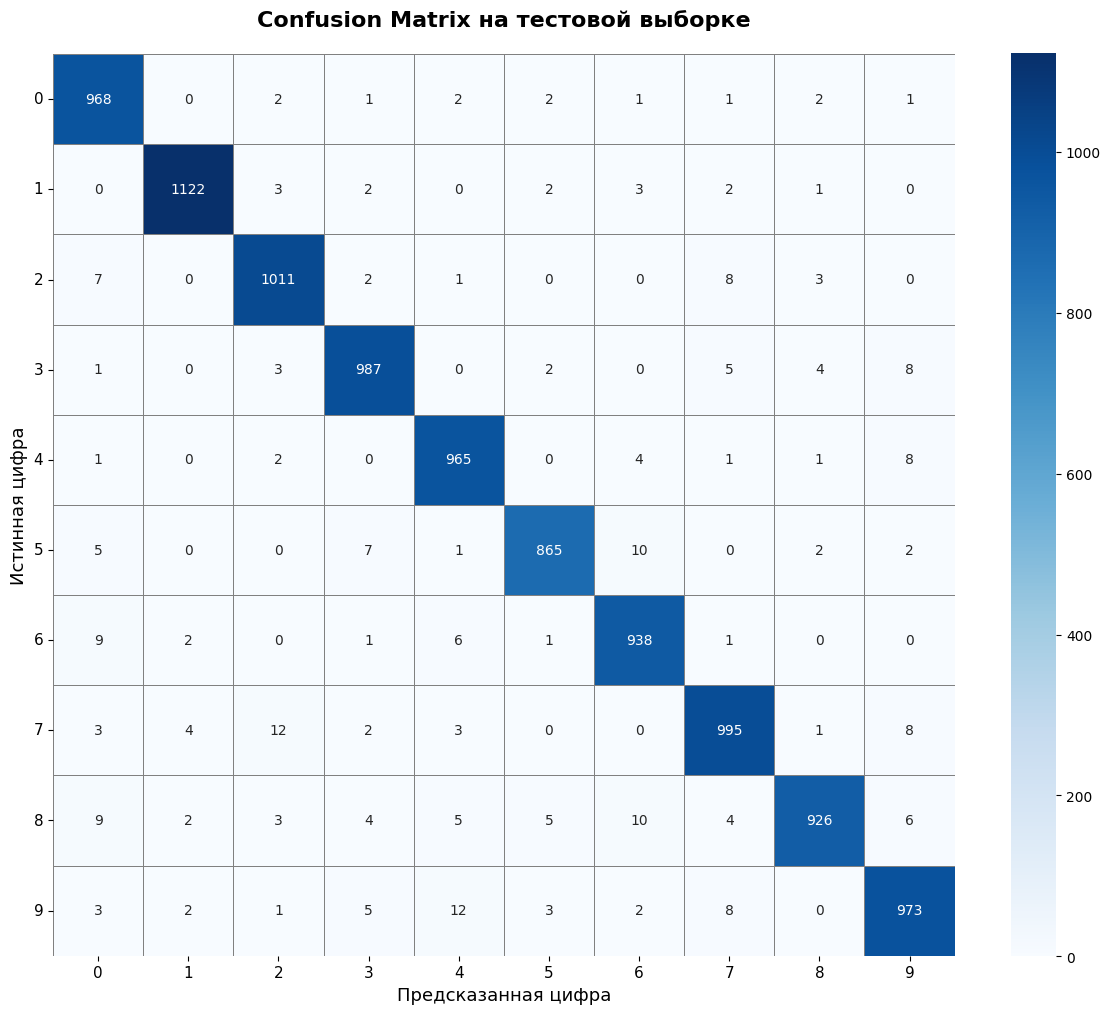


Наиболее частые ошибки классификации:
--------------------------------------------------
Цифра 9 классифицирована как 4: 12 раз (1.2% от всех 9)
Цифра 7 классифицирована как 2: 12 раз (1.2% от всех 7)
Цифра 8 классифицирована как 6: 10 раз (1.0% от всех 8)
Цифра 5 классифицирована как 6: 10 раз (1.1% от всех 5)
Цифра 8 классифицирована как 0: 9 раз (0.9% от всех 8)
Цифра 6 классифицирована как 0: 9 раз (0.9% от всех 6)
Цифра 9 классифицирована как 7: 8 раз (0.8% от всех 9)
Цифра 7 классифицирована как 9: 8 раз (0.8% от всех 7)
Цифра 4 классифицирована как 9: 8 раз (0.8% от всех 4)
Цифра 3 классифицирована как 9: 8 раз (0.8% от всех 3)


In [10]:
# ============================================================
# БЛОК 9: CONFUSION MATRIX (МАТРИЦА ОШИБОК)
# ============================================================
# Confusion Matrix показывает, какие цифры модель путает между собой
# Строки - истинные метки, столбцы - предсказанные метки

print('\n' + '='*70)
print('ПОСТРОЕНИЕ CONFUSION MATRIX')
print('='*70)

# Вычисляем confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Визуализируем confusion matrix
plt.figure(figsize=(12, 10))

# Создаем heatmap с аннотациями
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            square=True, linewidths=0.5, linecolor='gray')

plt.title('Confusion Matrix на тестовой выборке', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Предсказанная цифра', fontsize=13)
plt.ylabel('Истинная цифра', fontsize=13)
plt.xticks(np.arange(10) + 0.5, range(10), fontsize=11)
plt.yticks(np.arange(10) + 0.5, range(10), fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

# Анализируем наиболее частые ошибки
print('\nНаиболее частые ошибки классификации:')
print('-' * 50)

# Создаем список ошибок (исключая диагональ)
errors = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            errors.append((cm[i, j], i, j))

# Сортируем по количеству ошибок
errors.sort(reverse=True)

# Выводим топ-10 ошибок
for count, true_label, pred_label in errors[:10]:
    percentage = 100 * count / np.sum(test_labels == true_label)
    print(f'Цифра {true_label} классифицирована как {pred_label}: '
          f'{count} раз ({percentage:.1f}% от всех {true_label})')


ВИЗУАЛИЗАЦИЯ ОШИБОК МОДЕЛИ

Найдено 20 неправильно классифицированных примеров


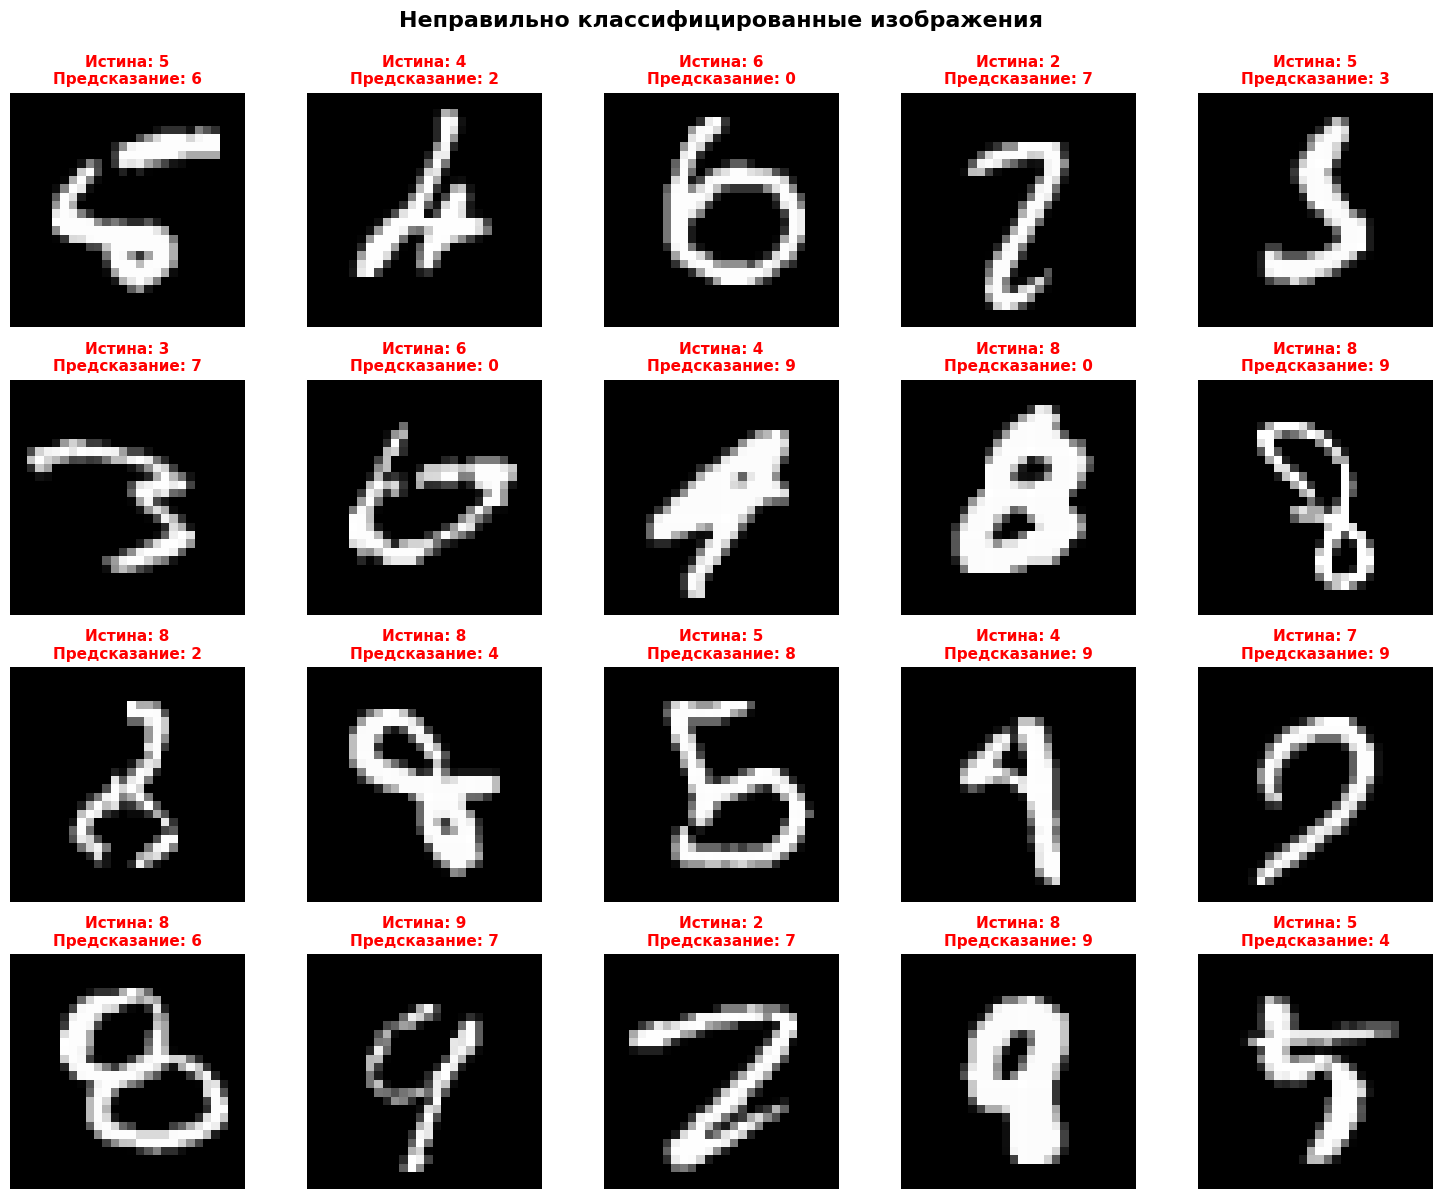


Статистика ошибок в найденных примерах:
--------------------------------------------------
Наиболее частые пары (истина -> предсказание):
  6 -> 0: 2 раз
  2 -> 7: 2 раз
  4 -> 9: 2 раз
  8 -> 9: 2 раз
  5 -> 6: 1 раз


In [11]:
# ============================================================
# БЛОК 10: ВИЗУАЛИЗАЦИЯ НЕПРАВИЛЬНО КЛАССИФИЦИРОВАННЫХ ИЗОБРАЖЕНИЙ
# ============================================================
# Здесь мы найдем и покажем изображения, которые модель классифицировала неправильно

print('\n' + '='*70)
print('ВИЗУАЛИЗАЦИЯ ОШИБОК МОДЕЛИ')
print('='*70)

# Функция для получения неправильно классифицированных примеров
def get_misclassified_examples(model, dataloader, device, num_examples=20):
    """
    Находит неправильно классифицированные примеры

    Параметры:
    - num_examples: сколько примеров найти

    Возвращает:
    - misclassified_images: изображения
    - misclassified_true: истинные метки
    - misclassified_pred: предсказанные метки
    """
    model.eval()

    misclassified_images = []
    misclassified_true = []
    misclassified_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images_gpu = images.to(device)
            outputs = model(images_gpu)
            _, predicted = torch.max(outputs, 1)

            # Находим неправильные предсказания
            mask = predicted.cpu() != labels

            if mask.sum() > 0:
                wrong_images = images[mask]
                wrong_true = labels[mask]
                wrong_pred = predicted.cpu()[mask]

                misclassified_images.extend(wrong_images)
                misclassified_true.extend(wrong_true.numpy())
                misclassified_pred.extend(wrong_pred.numpy())

                # Если собрали достаточно примеров, останавливаемся
                if len(misclassified_images) >= num_examples:
                    break

    return (misclassified_images[:num_examples],
            misclassified_true[:num_examples],
            misclassified_pred[:num_examples])

# Получаем 20 неправильно классифицированных примеров
mis_images, mis_true, mis_pred = get_misclassified_examples(model, test_loader, device, num_examples=20)

print(f'\nНайдено {len(mis_images)} неправильно классифицированных примеров')

# Визуализируем неправильно классифицированные примеры
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Неправильно классифицированные изображения',
             fontsize=16, fontweight='bold', y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(mis_images):
        # Получаем изображение
        img = mis_images[idx].squeeze().numpy()

        # Отображаем изображение
        ax.imshow(img, cmap='gray')

        # Добавляем подпись с истинной и предсказанной меткой
        true_label = mis_true[idx]
        pred_label = mis_pred[idx]

        ax.set_title(f'Истина: {true_label}\nПредсказание: {pred_label}',
                    fontsize=11, color='red', fontweight='bold')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Статистика по ошибкам
print('\nСтатистика ошибок в найденных примерах:')
print('-' * 50)
error_pairs = {}
for true, pred in zip(mis_true, mis_pred):
    pair = (true, pred)
    error_pairs[pair] = error_pairs.get(pair, 0) + 1

print('Наиболее частые пары (истина -> предсказание):')
sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)
for (true, pred), count in sorted_errors[:5]:
    print(f'  {true} -> {pred}: {count} раз')


ПРОВЕРКА МОДЕЛИ НА СЛУЧАЙНЫХ ПРИМЕРАХ


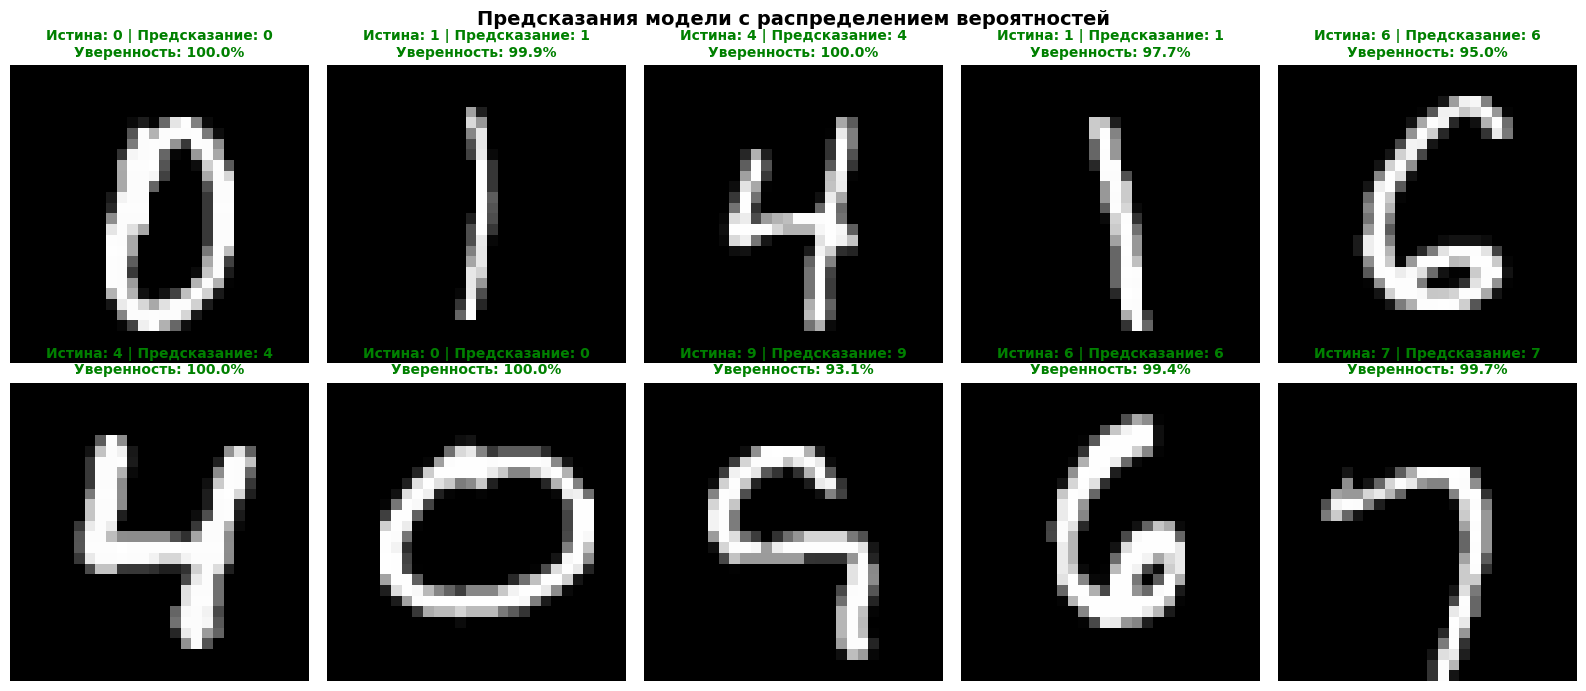


Детальная информация для первого примера:
--------------------------------------------------
Истинная метка: 0

Вероятности для каждого класса:
  Цифра 0: 100.00% █████████████████████████████████████████████████
  Цифра 1:  0.00% 
  Цифра 2:  0.00% 
  Цифра 3:  0.00% 
  Цифра 4:  0.00% 
  Цифра 5:  0.00% 
  Цифра 6:  0.00% 
  Цифра 7:  0.00% 
  Цифра 8:  0.00% 
  Цифра 9:  0.00% 


In [13]:
# ============================================================
# БЛОК 11: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ И ПРОВЕРКА НА СЛУЧАЙНЫХ ПРИМЕРАХ
# ============================================================

print('\n' + '='*70)
print('ПРОВЕРКА МОДЕЛИ НА СЛУЧАЙНЫХ ПРИМЕРАХ')
print('='*70)

# Функция для визуализации предсказаний с вероятностями
def visualize_predictions_with_probabilities(model, dataloader, device, num_samples=10):
    """
    Визуализирует предсказания модели с распределением вероятностей
    """
    model.eval()

    # Получаем один батч
    images, labels = next(iter(dataloader))

    # Выбираем случайные примеры
    indices = np.random.choice(len(images), num_samples, replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(16, 7))
    fig.suptitle('Предсказания модели с распределением вероятностей',
                 fontsize=14, fontweight='bold')

    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    for idx, ax in enumerate(axes.flat):
        img_idx = indices[idx]

        # Изображение
        img = images[img_idx].squeeze().numpy()
        true_label = labels[img_idx].item()
        pred_label = predictions[img_idx].cpu().item()
        probs = probabilities[img_idx].cpu().numpy()

        # Определяем цвет рамки (зеленый - правильно, красный - неправильно)
        color = 'green' if true_label == pred_label else 'red'

        # Отображаем изображение
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Истина: {true_label} | Предсказание: {pred_label}\n'
                    f'Уверенность: {probs[pred_label]*100:.1f}%',
                    fontsize=10, color=color, fontweight='bold')
        ax.axis('off')

        # Добавляем рамку
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
            spine.set_visible(True)

    plt.tight_layout()
    plt.show()

    # Выводим детальную информацию для первого примера
    print('\nДетальная информация для первого примера:')
    print('-' * 50)
    img_idx = indices[0]
    probs = probabilities[img_idx].cpu().numpy()
    true_label = labels[img_idx].item()

    print(f'Истинная метка: {true_label}')
    print('\nВероятности для каждого класса:')
    for digit in range(10):
        bar = '█' * int(probs[digit] * 50)
        print(f'  Цифра {digit}: {probs[digit]*100:5.2f}% {bar}')

# Визуализируем предсказания
visualize_predictions_with_probabilities(model, test_loader, device, num_samples=10)

In [14]:
# ============================================================
# БЛОК 12: ИТОГОВАЯ ИНФОРМАЦИЯ И СОХРАНЕНИЕ
# ============================================================

print('\n' + '='*70)
print('ИТОГОВАЯ ИНФОРМАЦИЯ О МОДЕЛИ')
print('='*70)

# Информация о модели
print('\n1. АРХИТЕКТУРА МОДЕЛИ:')
print('-' * 70)
print(model)

print(f'\n2. ПАРАМЕТРЫ МОДЕЛИ:')
print('-' * 70)
print(f'   Общее количество параметров: {total_params:,}')
print(f'   Размер модели в памяти: ~{total_params * 4 / (1024**2):.2f} MB (float32)')

print(f'\n3. НАСТРОЙКИ ОБУЧЕНИЯ:')
print('-' * 70)
print(f'   Количество эпох: {num_epochs}')
print(f'   Batch size: {batch_size}')
print(f'   Learning rate: {1e-3}')
print(f'   Оптимизатор: Adam')
print(f'   Функция потерь: CrossEntropyLoss')

print(f'\n4. РЕЗУЛЬТАТЫ НА ДАТАСЕТАХ:')
print('-' * 70)
print(f'   Train Accuracy: {train_accuracies[-1]:.2f}%')
print(f'   Validation Accuracy: {val_accuracies[-1]:.2f}%')
print(f'   Test Accuracy: {test_accuracy:.2f}%')

print(f'\n5. РАЗМЕРЫ ДАТАСЕТОВ:')
print('-' * 70)
print(f'   Train: {len(train_dataset)} изображений')
print(f'   Validation: {len(val_dataset)} изображений')
print(f'   Test: {len(test_dataset)} изображений')

print(f'\n6. ФАЙЛЫ МОДЕЛИ:')
print('-' * 70)
print(f'   ✓ Лучшая модель сохранена в: best_model.pth')

# Создаем итоговый отчет в виде словаря
final_report = {
    'model_architecture': 'MLP (784 -> 256 -> 128 -> 10)',
    'total_parameters': total_params,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': 1e-3,
    'optimizer': 'Adam',
    'train_accuracy': train_accuracies[-1],
    'val_accuracy': val_accuracies[-1],
    'test_accuracy': test_accuracy,
    'best_epoch': checkpoint['epoch'] + 1,
    'best_val_accuracy': checkpoint['val_accuracy']
}

print('\n' + '='*70)
print('РАБОТА ЗАВЕРШЕНА УСПЕШНО! ✓')
print('='*70)

print('\n📊 ИТОГОВЫЙ ОТЧЕТ:')
print(f"""
╔═══════════════════════════════════════════════════════════════╗
║                    РЕЗУЛЬТАТЫ ОБУЧЕНИЯ                        ║
╠═══════════════════════════════════════════════════════════════╣
║  Архитектура: {final_report['model_architecture']:<45} ║
║  Параметров: {final_report['total_parameters']:>46,} ║
║  Эпох обучения: {final_report['num_epochs']:>44} ║
╠═══════════════════════════════════════════════════════════════╣
║  Train Accuracy: {final_report['train_accuracy']:>42.2f}% ║
║  Validation Accuracy: {final_report['val_accuracy']:>37.2f}% ║
║  Test Accuracy: {final_report['test_accuracy']:>43.2f}% ║
╠═══════════════════════════════════════════════════════════════╣
║  Лучшая эпоха: {final_report['best_epoch']:>45} ║
║  Лучшая Val Accuracy: {final_report['best_val_accuracy']:>37.2f}% ║
╚═══════════════════════════════════════════════════════════════╝
""")

print('\n💡 Следующие шаги:')
print('   1. Попробуйте изменить архитектуру (больше слоев, больше нейронов)')
print('   2. Поэкспериментируйте с dropout и batch normalization')
print('   3. Попробуйте другие оптимизаторы (SGD, RMSprop)')
print('   4. Используйте data augmentation для улучшения результатов')
print('   5. Попробуйте сверточную сеть (CNN) для еще лучших результатов')

print('\n' + '='*70)


ИТОГОВАЯ ИНФОРМАЦИЯ О МОДЕЛИ

1. АРХИТЕКТУРА МОДЕЛИ:
----------------------------------------------------------------------
MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

2. ПАРАМЕТРЫ МОДЕЛИ:
----------------------------------------------------------------------
   Общее количество параметров: 235,146
   Размер модели в памяти: ~0.90 MB (float32)

3. НАСТРОЙКИ ОБУЧЕНИЯ:
----------------------------------------------------------------------
   Количество эпох: 10
   Batch size: 128
   Learning rate: 0.001
   Оптимизатор: Adam
   Функция потерь: CrossEntropyLoss

4. РЕЗУЛЬТАТЫ НА ДАТАСЕТАХ:
----------------------------------------------------------------------
   Train Accuracy: 97.31%
   Validation Accuracy: 97.47%
   Test Accuracy: 97.50%

5. РАЗМЕРЫ ДАТАСЕТОВ:
---------------------